<a href="https://colab.research.google.com/github/nxshi/IDS131F21/blob/main/ProblemSets/TimeSeries%2BStateSpaceModels/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 2.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ps3/PriceStats_CPI.csv')

In [ ]:
current = 0

cpi_list = []
date_list = []
month_list = []

for i in range(len(df['date'])):

    month = int(df['date'][i][5:7])
    
    if month != current:
        current = month
        
        date = df['date'][i][0:7]
        date_list.append(date)        
        cpi_list.append(df['CPI'][i])
        month_list.append(month)

In [ ]:
current = 0

ps_list = []
date_list = []
month_list = []

for i in range(len(df['date'])):

    month = int(df['date'][i][5:7])
    
    if month != current:
        current = month
        
        date = df['date'][i][0:7]
        date_list.append(date)        
        ps_list.append(df['CPI'][i])
        month_list.append(month)

In [ ]:
CPI = pd.DataFrame(list(zip(date_list, cpi_list, month_list)),
               columns =['date', 'CPI','month'])
PriceStats = pd.DataFrame(list(zip(date_list, cpi_list, month_list)),
               columns =['date', 'PriceStats','month'])

In [ ]:
#get
CPI = CPI[CPI['CPI'].notna()]
PriceStats = PriceStats[PriceStats['PriceStats'].notna()]

In [ ]:
CPI.shape

(123, 3)

In [ ]:
CPI= CPI.dropna(how="any")
PriceStats = PriceStats.dropna(how='any')

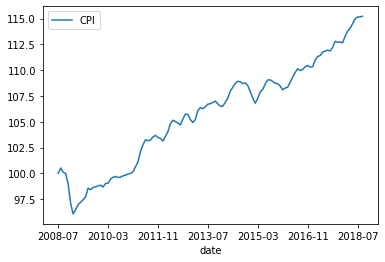

In [ ]:
CPI.plot(x='date', y='CPI')
dff = CPI

In [ ]:
'''CPI['CPI_log'] = np.log(CPI['CPI'])
CPI = CPI.drop(CPI.index[0])'''

"CPI['CPI_log'] = np.log(CPI['CPI'])\nCPI = CPI.drop(CPI.index[0])"

In [ ]:
'''from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['CPI'], model='multiplicable', period=12)'''

"from statsmodels.tsa.seasonal import seasonal_decompose\nresult=seasonal_decompose(df['CPI'], model='multiplicable', period=12)"

In [ ]:
# Convert to rates
rate_CPI_list = []
for t in range(len(CPI['CPI'])):
  Xt = CPI['CPI'].iloc[t]
  Xt_1 = CPI['CPI'].iloc[t-1]
  rate = ((Xt - Xt_1 )/ Xt_1 )*100
  rate_CPI_list.append(rate)

CPI['CPI_rate'] = rate_CPI_list
CPI = CPI.drop(1)

#CPI.plot(x='date', y='CPI_rate',figsize=(20, 10))
#((B - A)/A)*100

rate_PS_list = []
for t in range(len(PriceStats['PriceStats'])):
  Xt = PriceStats['PriceStats'].iloc[t]
  Xt_1 = PriceStats['PriceStats'].iloc[t-1]
  rate = ((Xt - Xt_1 )/ Xt_1 )*100
  rate_PS_list.append(rate)

PriceStats['PriceStats'] = rate_PS_list
PriceStats = PriceStats.drop(1)

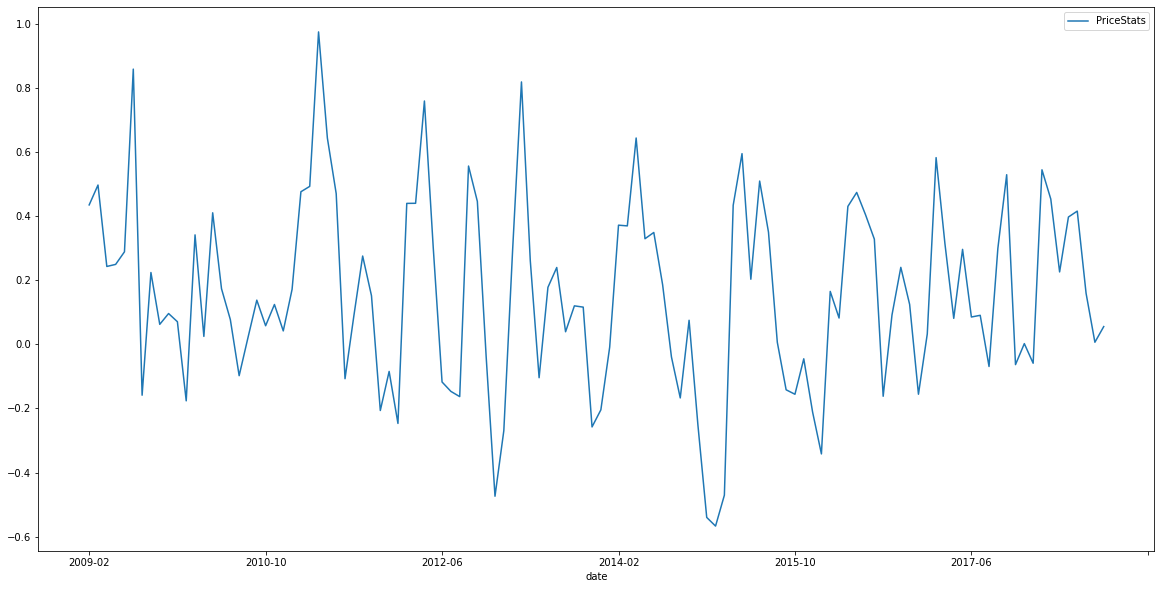

In [ ]:
PriceStats = PriceStats.iloc[6:]
PriceStats.plot(x='date', y='PriceStats',figsize=(20, 10))

CPI is and index
BER is the break-even rate is a rate
PriceStats is an index

First want to turn everything into a rate and do a log transform according to: 

$CPI_{rate} = \log(X_{t} /X_{t-1})  $

In [ ]:
'''rate_CPI_list = []

for t in range(len(CPI['CPI'])):
    
    try:
        Xt = CPI['CPI'].iloc[t]
        Xt_1 = CPI['CPI'].iloc[t-1]
    
    except ValueError:
        continue
    
    rate = np.log((Xt / Xt_1 ))
    rate_CPI_list.append(rate)
   




#rate_CPI_list.insert(0, np.nan)

CPI['CPI_rate'] = rate_CPI_list
#CPI['CPI_rate'].iloc[0] = np.nan

CPI = CPI.drop(1)

CPI.plot(x='date', y='CPI_rate',figsize=(20, 10))'''

"rate_CPI_list = []\n\nfor t in range(len(CPI['CPI'])):\n    \n    try:\n        Xt = CPI['CPI'].iloc[t]\n        Xt_1 = CPI['CPI'].iloc[t-1]\n    \n    except ValueError:\n        continue\n    \n    rate = np.log((Xt / Xt_1 ))\n    rate_CPI_list.append(rate)\n   \n\n\n\n\n#rate_CPI_list.insert(0, np.nan)\n\nCPI['CPI_rate'] = rate_CPI_list\n#CPI['CPI_rate'].iloc[0] = np.nan\n\nCPI = CPI.drop(1)\n\nCPI.plot(x='date', y='CPI_rate',figsize=(20, 10))"

We are observe what appears to be a random walk behavior, except at the beggining around the late 2008 months. This drastic drop can be attributed to the great recession which was an anomoly. I will therefor drop these first few months so that the fit can work better on the more "normal" months.

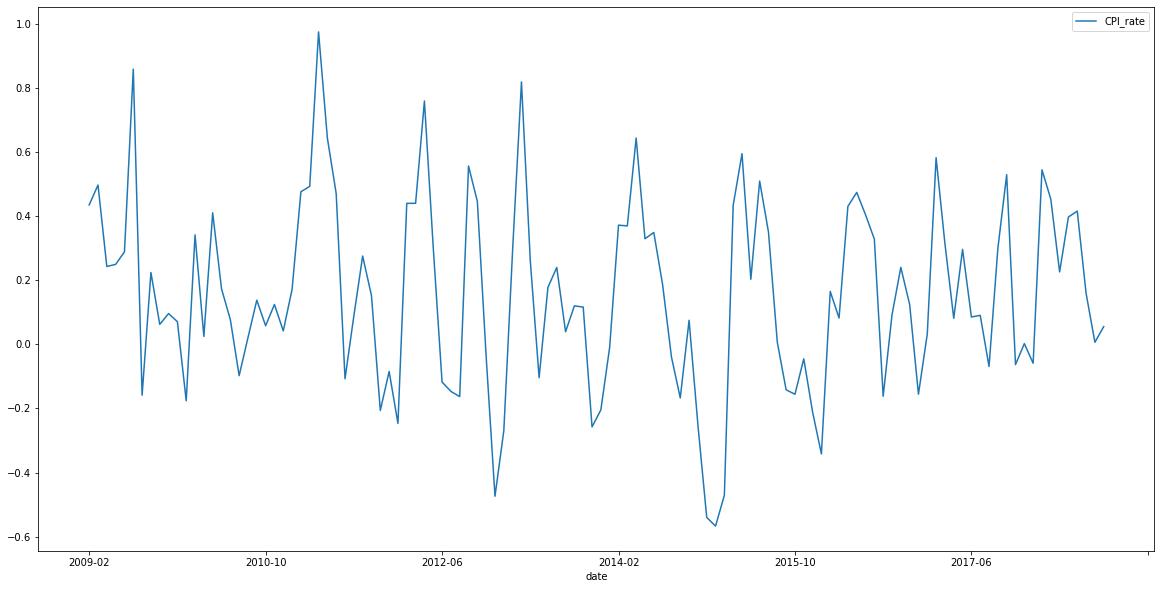

In [ ]:
CPI = CPI.iloc[6:]
CPI.plot(x='date', y='CPI_rate',figsize=(20, 10))

Better!

## Extracting seasonality

Now I will run the Dicker-Fuller test to see if there is weak stationarity

In [ ]:
ad_fuller_result = adfuller(CPI['rate'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

KeyError: ignored

In [ ]:
ad_fuller_result = adfuller(PriceStats['PriceStats'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.2112261359962506
p-value: 0.20219627642695842


Since the p-value > 0.05 we can not reject the null hypothesis and say that our time series is stationary.

Therefore I will attempt to remove the seasonality

In [ ]:
# groupby months and take average
monthly_avg = CPI.groupby(['month']).mean()
residual_monthly = monthly_avg['CPI_rate']
monthly_avg1 = PriceStats.groupby(['month']).mean()
residual_monthly1 = monthly_avg1['PriceStats']

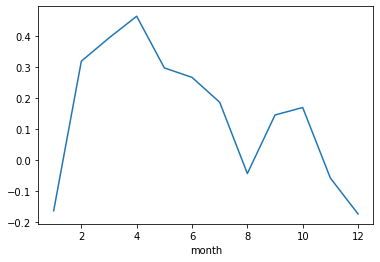

In [ ]:
# Plot residual average by month
# seasonal_decomponse(cpi, model='addidteve, period=12
residual_monthly.plot()

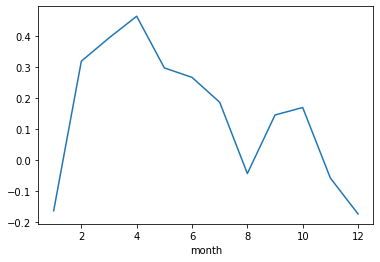

In [ ]:
residual_monthly1.plot()

In [ ]:
ser = pd.Series()

for i in range(1,13):

    gb = PriceStats.groupby(['month'])
    gg = gb.get_group(i)
    rate_month = gg['PriceStats']
    adj_rate_month = rate_month - residual_monthly1[i]

    ser = ser.append(adj_rate_month)

    
# sort by index to find compare to column 6  
seasonally_adj_rate_data = ser.sort_index(ascending=True)
seasonally_adj_rate_data

PriceStats['rate_seas_adj'] = seasonally_adj_rate_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
ser = pd.Series()

for i in range(1,13):

    gb = CPI.groupby(['month'])
    gg = gb.get_group(i)
    rate_month = gg['CPI_rate']
    adj_rate_month = rate_month - residual_monthly[i]

    ser = ser.append(adj_rate_month)

    
# sort by index to find compare to column 6  
seasonally_adj_rate_data = ser.sort_index(ascending=True)
seasonally_adj_rate_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


7      0.116907
8      0.104376
9     -0.219528
10    -0.047014
11     0.022635
         ...   
118    0.100814
119    0.149645
120   -0.026858
121    0.049568
122   -0.089727
Length: 116, dtype: float64

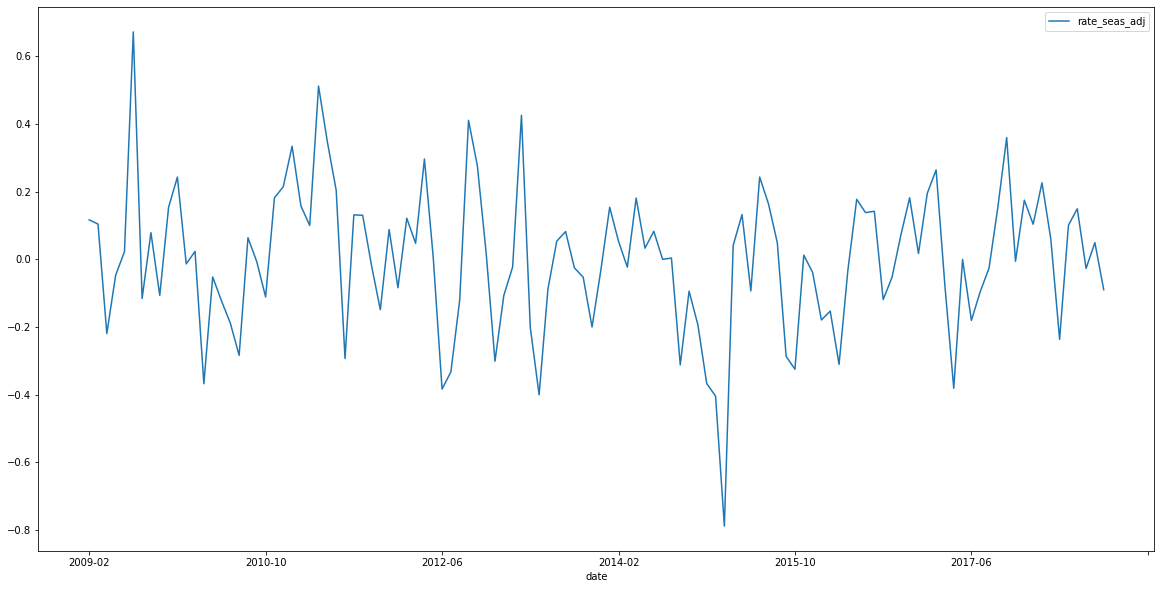

In [ ]:
CPI['rate_seas_adj'] = seasonally_adj_rate_data
CPI.plot(x='date', y='rate_seas_adj',figsize=(20, 10))

In [ ]:
PriceStats

,date,PriceStats,month,rate_seas_adj
7,2009-02,0.435240,2,0.116907
8,2009-03,0.497275,3,0.104376
9,2009-04,0.243179,4,-0.219528
10,2009-05,0.249636,5,-0.047014
11,2009-06,0.288880,6,0.022635
...,...,...,...,...
118,2018-05,0.397464,5,0.100814
119,2018-06,0.415890,6,0.149645
120,2018-07,0.159422,7,-0.026858
121,2018-08,0.006686,8,0.049568


In [ ]:
PriceStats[PriceStats['date']=='2013-09']

,date,PriceStats,month,rate_seas_adj
62,2013-09,0.120275,9,-0.025022


The PCAF looks a better. Now I will run the Dicker-Fuller test to see if there is weak stationarity.

In [ ]:
ad_fuller_result = adfuller(CPI['rate_seas_adj'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.740569462827353
p-value: 1.0646733388985513e-11


Since we get a large negative ADF statistic and p-value smaller than 0.05, we can reject the null hypothesis and say that our time series is stationary.

## Autocorrelation Analysis

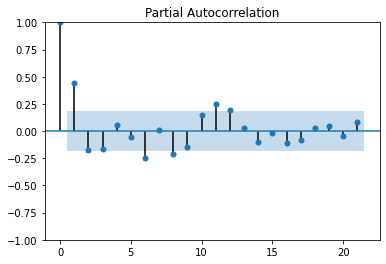

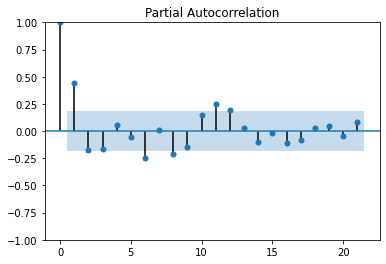

In [ ]:
'''from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(CPI['CPI_rate'], method='ywm')
plot_acf(CPI['CPI_rate'], bartlett_confint=False)'''

The PACF seems to suggest that the p=2 such that AR(2), so I will build my autoregressive model of a second order

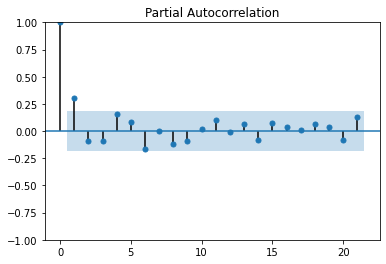

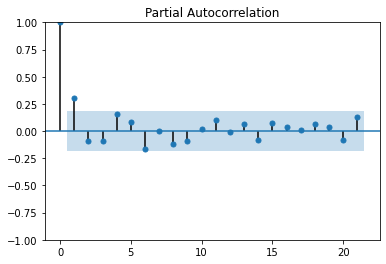

In [ ]:
plot_pacf(CPI['rate_seas_adj'], method='ywm')

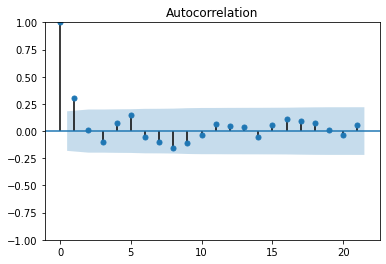

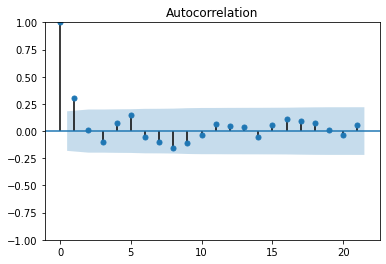

In [ ]:
plot_acf(CPI['rate_seas_adj'])

## Train

In [ ]:
mse_list

[0.041341722179298254,
 0.04187598740784035,
 0.04180269694133178,
 0.04125570033012143,
 0.03950544569748542,
 0.041050931407667066,
 0.04067522518315795,
 0.03985849710678133,
 0.039862866591382086,
 0.03993425901085733,
 0.0401728445382611,
 0.03995125341790448,
 0.04072845736140278,
 0.04141000119215013,
 0.045360500642239086,
 0.05358733657119164,
 0.07019058827792268]

## AR Model with different orders



In [ ]:
from math import sqrt
train, test = CPI[1:len(CPI)-61], CPI[len(CPI)-61:]
train_CPI = train['rate_seas_adj']
test_CPI = test['rate_seas_adj']




In [ ]:
train1, test1 = PriceStats[1:len(PriceStats)-61], PriceStats[len(PriceStats)-61:]
train_ps = train1['rate_seas_adj']
test_ps = test1['rate_seas_adj']

In [ ]:
train1.tail()

,date,PriceStats,month,rate_seas_adj
57,2013-04,0.261448,4,-0.225652
58,2013-05,-0.103968,5,-0.405842
59,2013-06,0.178040,6,-0.085690
60,2013-07,0.240002,7,0.128466
61,2013-08,0.039452,8,0.082333


In [ ]:
train.tail()

,date,CPI,month,CPI_rate,rate_seas_adj
57,2013-04,106.3789,4,0.261448,-0.201260
58,2013-05,106.2683,5,-0.103968,-0.400618
59,2013-06,106.4575,6,0.178040,-0.088205
60,2013-07,106.7130,7,0.240002,0.053721
61,2013-08,106.7551,8,0.039452,0.082333


In [ ]:
test.head()

,date,CPI,month,CPI_rate,rate_seas_adj
62,2013-09,106.8835,9,0.120275,-0.025022
63,2013-10,107.0078,10,0.116295,-0.053102
64,2013-11,106.7322,11,-0.257551,-0.200154
65,2013-12,106.5142,12,-0.204250,-0.031611
66,2014-01,106.5051,1,-0.008543,0.154068


In [ ]:
orders = list(range(1,24))
mse_list = []
predicted_orders = []
for order in orders:
  model = AutoReg(train_ps, lags=order)
  model_fit = model.fit()
  predicted_val = []
  for i in range(62, 123):
    predicted = model_fit.params[0]
    for j in range(1 , len(model_fit.params)):
      predicted = predicted + model_fit.params[j] * PriceStats['rate_seas_adj'][i - j]
    predicted_val.append(predicted)


  predicted_orders.append(predicted_val)
  mse = mean_squared_error(test_ps[:-1],predicted_val[1:])
  mse_list.append(mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was pro

In [ ]:
mse_list

[0.01928077221388385,
 0.022235755122287836,
 0.023450543980409345,
 0.02138125829148583,
 0.021973833461727033,
 0.021800523909586072,
 0.019956540582434148,
 0.021907905511560806,
 0.02751876064092926,
 0.034823771556594656,
 0.0338666969329927,
 0.03324724919014256,
 0.03549150011247469,
 0.04315923002801548,
 0.03522115217697462,
 0.03297371209138087,
 0.03293682888874557,
 0.0472038041826119,
 0.056760441290405375,
 0.13526506380549072,
 0.11238257715559628,
 0.12074162371241061,
 0.21076934713058165]

In [ ]:
orders = list(range(1,24))
mse_list = []
predicted_orders = []
for order in orders:
  model = AutoReg(train_CPI, lags=order)
  model_fit = model.fit()
  predicted_values = []
  for i in range(62, 123):
    predicted = model_fit.params[0]
    for j in range(1 , len(model_fit.params)):
      predicted = predicted + model_fit.params[j] * CPI['rate_seas_adj'][i - j]
    predicted_values.append(predicted)


  predicted_orders.append(predicted_values)
  mse = mean_squared_error(test_CPI[:-1],predicted_values[1:])
  mse_list.append(mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was pro

In [ ]:
len(test_CPI)

61

In [ ]:
mse_list

[0.025332228899237887,
 0.027858321797333194,
 0.03369823730791941,
 0.027506389955412252,
 0.027901649021716917,
 0.022987192903469376,
 0.022564144470924176,
 0.02509359783027902,
 0.029859134209791204,
 0.03185215876727266,
 0.02979028942534761,
 0.029780018625909364,
 0.02868537788412806,
 0.030499259158258487,
 0.03834204677346904,
 0.03852863844314345,
 0.04681884387075971,
 0.041470577774241985,
 0.04178979977971463,
 0.07006300344884081,
 0.04676075726229302,
 0.061778779975436335,
 0.11496704917489603]

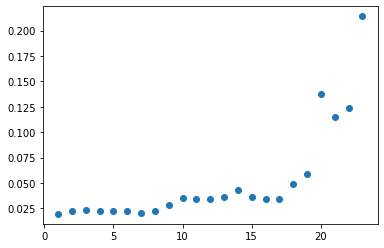

In [ ]:
plt.scatter(orders, mse_list)

In [ ]:
min(mse_list)

0.022564144470924176

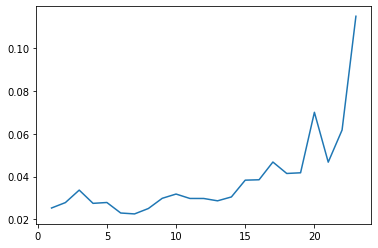

In [ ]:
plt.plot(orders,mse_list)

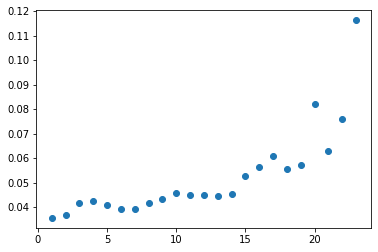

In [ ]:
plt.scatter(orders, mse_list)

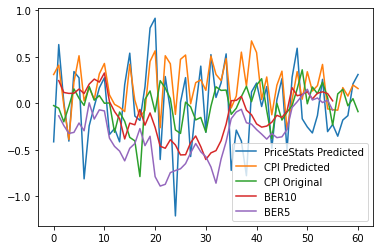

In [ ]:
plt.plot(predicted_val, label = 'PriceStats Predicted')
plt.plot(predicted_values, label = 'CPI Predicted')
plt.plot(test_CPI.values, label = 'CPI Original')
plt.plot(range(1,56),BER10[116:]['T10YIE'].values, label = 'BER10')
plt.plot(range(1,56),BER5[116:]['T5YIE'].values, label = 'BER5')
plt.legend()

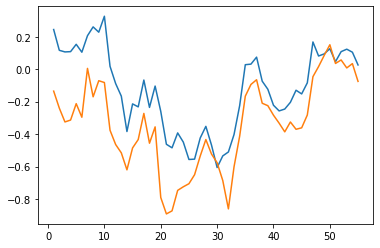

In [ ]:
plt.plot(range(1,56),BER10[116:]['T10YIE'].values)
plt.plot(range(1,56),BER5[116:]['T5YIE'].values)

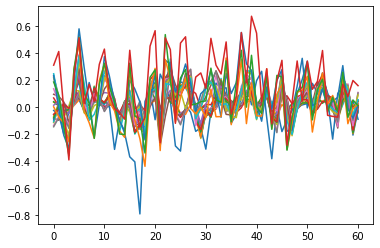

In [ ]:
plt.plot(test_CPI.values)
for x in predicted_orders:
  plt.plot(x)

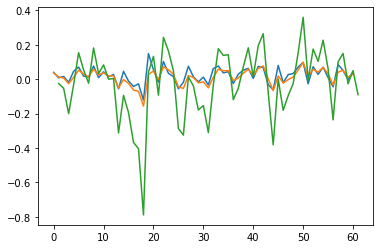

In [ ]:
plt.plot(predicted_list)
plt.plot(predicted_orders[0])
plt.plot(range(1, 62), test_CPI.values)

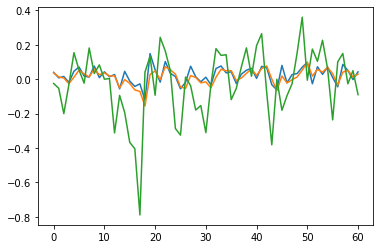

In [ ]:
plt.plot(predicted_list)
plt.plot(predicted_orders[0])
plt.plot( test_CPI.values)

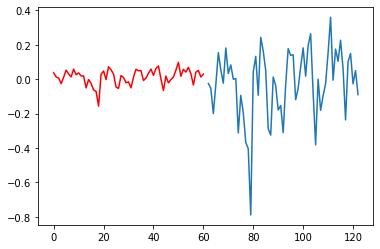

In [ ]:
# plot results
plt.plot(test_CPI)
plt.plot(predicted_orders[0], color='red')
plt.show()

## Les' AR model

In [ ]:
#
# Create training and test data
#
train_indx = CPI[CPI['date']=='2013-08'].index.values[0]

train = CPI['rate_seas_adj'][:train_indx+1]
test = CPI['rate_seas_adj'][train_indx+1 :]
#
# Initiate and fit the AR model with training data
#
ar_model = AutoReg(train, lags=2)
model_fit = ar_model.fit()
#
# Print Summary
#
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:          rate_seas_adj   No. Observations:                   55
Model:                     AutoReg(2)   Log Likelihood                 248.801
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Mon, 01 Nov 2021   AIC                           -489.602
Time:                        23:55:31   BIC                           -481.721
Sample:                             2   HQIC                          -486.572
                                   55                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002      0.000      0.698      0.485      -0.000       0.001
rate_seas_adj.L1     0.2550      0.136      1.878      0.060      -0.011       0.521
rate_seas_adj.L2    -0.1496 

In [ ]:
# coefficient of model doesnt change, but you apply it to the new 

dir(model_fit)
model_fit.params

const               0.000214
rate_seas_adj.L1    0.254959
rate_seas_adj.L2   -0.149577
dtype: float64

In [ ]:
# make predictions
#predictions = ar_model.predict(params=model_fit.params, start=train_indx, end=len(CPI['rate']), dynamic=False)

#for i in predictions:
#   print(i)

# make list of predicted values by taking real data and multiplying it by the estimated parameters of the model
predicted_list = []    
for i in range(train_indx+1, CPI['rate_seas_adj'].index.max()+1):    
    
    predicted = model_fit.params[0] + model_fit.params[1] * CPI['rate_seas_adj'][i-1] + model_fit.params[2] * CPI['rate_seas_adj'][i-2]
    predicted_list.append(predicted)
    
print(predicted_list)    
    

[0.0003434556182036287, 2.7805751427815474e-05, 0.00011658545810874343, -0.00021761260603507017, 0.00043369106263688124, 0.000654984856512901, 0.00012063852091412868, 7.544414538331989e-05, 0.0007089031132247142, 2.8364045077871355e-05, 0.00037619264873119275, 9.10783681463188e-05, 0.00022361335245149098, -0.0005875850241376823, 0.00044193598133625565, -0.00014014123940756144, -0.0004348923777291861, -0.00026889383101570815, -0.001191003914417933, 0.001500106085735147, 0.00048926028906396, -0.00022039664095831028, 0.0009719233673032884, 0.0002692838420044956, 9.546199511601376e-05, -0.0005910973611652704, -0.00018501641270094165, 0.0007320243048445777, 9.785549922490031e-05, -0.00018590509139981677, 9.440512053439005e-05, -0.0003475597673546388, 0.0005967411291948292, 0.0007127527121087887, 0.00030150902957061206, 0.0003702438798263237, -0.0003020898281431235, 0.0002567172908589444, 0.00047490289670514555, 0.0005723583275972228, -1.3989351929147395e-05, 0.0006871722088080349, 0.0005937

In [ ]:
pred_CPI = CPI.iloc[train_indx+1:,:] 
pred_CPI['pred_rate'] = predicted_list
pred_CPI

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,date,CPI,month,rate,CPI_rate,rate_seas_adj,pred_rate
55,62,2013-09,106.8835,9,0.001202,0.001202,-0.000248,0.000343
56,63,2013-10,107.0078,10,0.001162,0.001162,-0.000528,0.000028
57,64,2013-11,106.7322,11,-0.002579,-0.002579,-0.002004,0.000117
58,65,2013-12,106.5142,12,-0.002045,-0.002045,-0.000315,-0.000218
59,66,2014-01,106.5051,1,-0.000085,-0.000085,0.001544,0.000434
...,...,...,...,...,...,...,...,...
111,118,2018-05,114.5013,5,0.003967,0.003967,0.001006,-0.000477
112,119,2018-06,114.9775,6,0.004150,0.004150,0.001493,0.000823
113,120,2018-07,115.1608,7,0.001593,0.001593,-0.000264,0.000444
114,121,2018-08,115.1685,8,0.000067,0.000067,0.000496,-0.000077


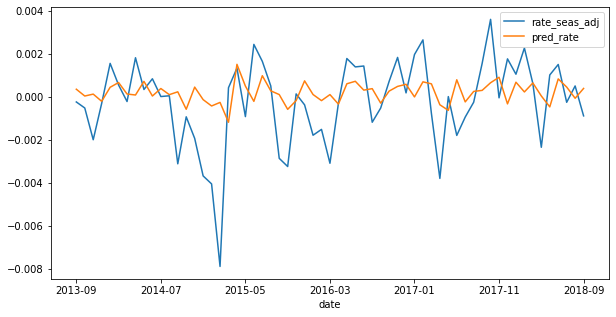

In [ ]:
pred_CPI.plot(x='date', y=['rate_seas_adj', 'pred_rate'], figsize=(10,5))

In [ ]:
CPI

,index,date,CPI,month,rate,CPI_rate,rate_seas_adj
0,7,2009-02,96.49385,2,0.004343,0.004343,0.001169
1,8,2009-03,96.97369,3,0.004960,0.004960,0.001041
2,9,2009-04,97.20951,4,0.002429,0.002429,-0.002184
3,10,2009-05,97.45218,5,0.002493,0.002493,-0.000467
4,11,2009-06,97.73370,6,0.002885,0.002885,0.000228
...,...,...,...,...,...,...,...
111,118,2018-05,114.50130,5,0.003967,0.003967,0.001006
112,119,2018-06,114.97750,6,0.004150,0.004150,0.001493
113,120,2018-07,115.16080,7,0.001593,0.001593,-0.000264
114,121,2018-08,115.16850,8,0.000067,0.000067,0.000496


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error('rate_seas_adj', 'pred_rate', sample_weight=None, multioutput='uniform_average', squared=True)

In [ ]:
from math import sqrt
# load dataset
#series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
#X = series.values

train, test = CPI[1:len(CPI)-7], CPI[len(CPI)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: ignored

In [ ]:
train

In [ ]:
CPI['rate_seas_adj'].index.max()

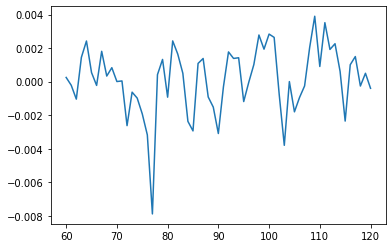

In [ ]:
test.plot()

In [ ]:
ad_fuller_result = adfuller(CPI['rate_seas_adj'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.199293970481231
p-value: 5.8604041803404685e-08


In [ ]:
# Try a AR(4) model
rho, sigma = yule_walker(CPI['CPI_rate'], 4)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [-0.66717789  0.20325769  0.08562058 -0.04838459]
sigma: 0.0030741911966841013


## part b)

In [ ]:
linear_fit = np.polyfit(dff.index, dff['CPI'], 1)
linear_fit

array([ 0.13811278, 97.34854198])

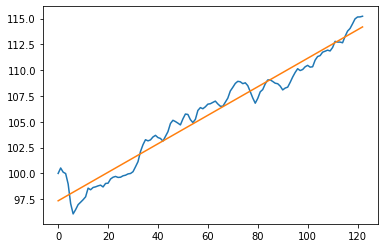

In [ ]:
xs = dff.index
ys = dff['CPI']

f = plt.figure()
ax = f.add_subplot(111)

ax.plot(xs,ys)
linearfit_poly = np.poly1d(linear_fit) 
ax.plot(xs,linearfit_poly(xs))



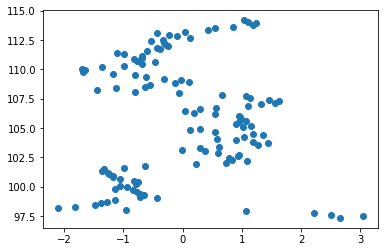

In [ ]:
m = linear_fit[0]
b = linear_fit[1]
y = ys
y_pred = m*xs + b
residuals = y - y_pred 

plt.scatter(residuals,y_pred)

plt.show()

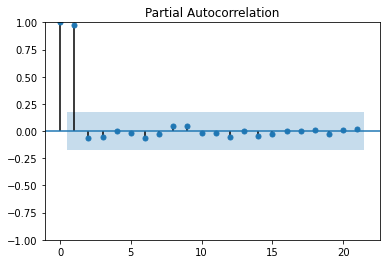

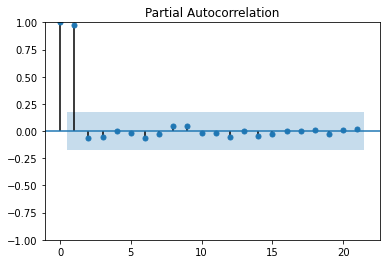

In [ ]:
# TURN OFF "correltant confindent" 


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dff['CPI'], method='ywm')

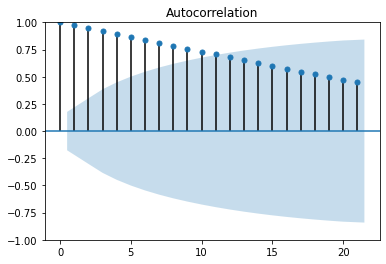

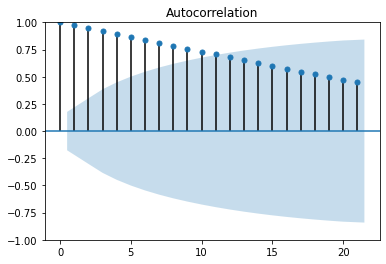

In [ ]:
plot_acf(dff['CPI'])

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ps3/T5YIE.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ps3/T10YIE.csv')

In [ ]:
df2

,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71
...,...,...
4131,2018-11-02,2.06
4132,2018-11-05,2.06
4133,2018-11-06,2.07
4134,2018-11-07,2.07


In [ ]:
for i in range(len(df1)+1):
  try:
    df1.loc[i,'T5YIE'] = float(df1.loc[i,'T5YIE'])-1 #**(1/12)-1
  except: ValueError
  try:
    df2.loc[i,'T10YIE'] = float(df2.loc[i,'T10YIE'])-1 #**(1/12)-1
  except: ValueError

In [ ]:
current = 0

df_list = []
date_list = []
month_list = []

for i in range(len(df1['DATE'])):
    try: month = int(df1['DATE'][i][5:7])
    except: ValueError
    if month != current:
        current = month
        date = df1['DATE'][i][0:7]
        date_list.append(date)        
        df_list.append(df1['T5YIE'][i])
        month_list.append(month)
BER5 = pd.DataFrame(list(zip(date_list, df_list, month_list)), columns =['DATE', 'T5YIE','month'])

In [ ]:
current = 0
df_list = []
date_list = []
month_list = []

for i in range(len(df2['DATE'])):
    try: month = int(df2['DATE'][i][5:7])
    except: ValueError
    if month != current:
        current = month 
        date = df2['DATE'][i][0:7]
        date_list.append(date)        
        df_list.append(df2['T10YIE'][i])
        month_list.append(month)
BER10 = pd.DataFrame(list(zip(date_list, df_list, month_list)), columns =['DATE', 'T10YIE','month'])

In [ ]:
BER10 = BER10[BER10['T10YIE']!='.']
BER10.loc[70,'T10YIE'] = np.real(BER10.loc[70,'T10YIE'])
BER10.loc[71,'T10YIE'] = np.real(BER10.loc[71,'T10YIE'])
BER5 = BER5[BER5['T5YIE']!='.']
BER5.loc[70,'T5YIE'] = np.real(BER5.loc[70,'T5YIE'])
BER5.loc[71,'T5YIE'] = np.real(BER5.loc[71,'T5YIE'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


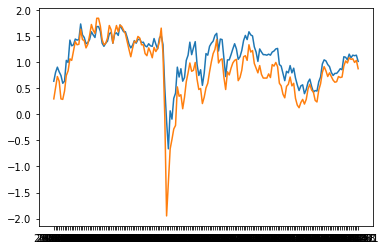

In [ ]:
plt.plot(BER10['DATE'],BER10['T10YIE'])
plt.plot(BER5['DATE'],BER5['T5YIE'])

In [ ]:
gg

,date,CPI,month,CPI_rate
17,2009-12,98.86433,12,0.070763
29,2010-12,99.99452,12,0.042060
41,2011-12,103.38870,12,-0.084367
53,2012-12,105.21260,12,-0.473828
65,2013-12,106.51420,12,-0.204250
77,2014-12,107.92270,12,-0.539957
89,2015-12,108.46430,12,-0.211052
101,2016-12,110.30010,12,-0.155515
113,2017-12,112.72950,12,0.002395


In [ ]:
gb.groups

{'2003-01': [0], '2003-02': [1], '2003-03': [2], '2003-04': [3], '2003-05': [4], '2003-06': [5], '2003-07': [6], '2003-08': [7], '2003-10': [9], '2003-11': [10], '2003-12': [11], '2004-02': [13], '2004-03': [14], '2004-04': [15], '2004-05': [16], '2004-06': [17], '2004-07': [18], '2004-08': [19], '2004-09': [20], '2004-10': [21], '2004-11': [22], '2004-12': [23], '2005-01': [24], '2005-02': [25], '2005-03': [26], '2005-04': [27], '2005-05': [28], '2005-06': [29], '2005-07': [30], '2005-08': [31], '2005-09': [32], '2005-10': [33], '2005-11': [34], '2005-12': [35], '2006-02': [37], '2006-03': [38], '2006-04': [39], '2006-05': [40], '2006-06': [41], '2006-07': [42], '2006-08': [43], '2006-09': [44], '2006-10': [45], '2006-11': [46], '2006-12': [47], '2007-02': [49], '2007-03': [50], '2007-04': [51], '2007-05': [52], '2007-06': [53], '2007-07': [54], '2007-08': [55], '2007-10': [57], '2007-11': [58], '2007-12': [59], '2008-02': [61], '2008-03': [62], '2008-04': [63], '2008-05': [64], '2008

In [ ]:
monthly_avg2 = BER5.groupby(['DATE']).mean()
residual_monthly2 = monthly_avg2

ser = pd.Series()

for i in range(1,13):

    gb = BER5.groupby(['DATE'])
    gg = gb.get_group(i)
    rate_month = gg['T5YIE']
    adj_rate_month = rate_month - residual_monthly2[i]

    ser = ser.append(adj_rate_month)
    
# sort by index to find compare to column 6  
seasonally_adj_rate_da

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


KeyError: ignored

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(abs(BER5['T5YIE']), model='multiplicable', period=12)
result.plot()

<bound method DecomposeResult.plot of <statsmodels.tsa.seasonal.DecomposeResult object at 0x7f3455bfaa10>>

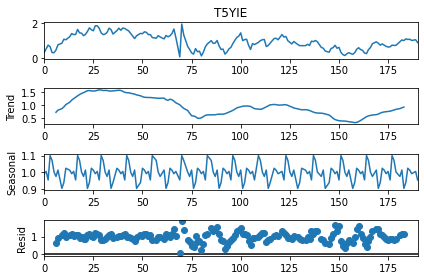

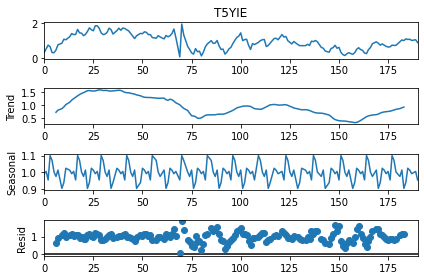

In [ ]:
result.plot()

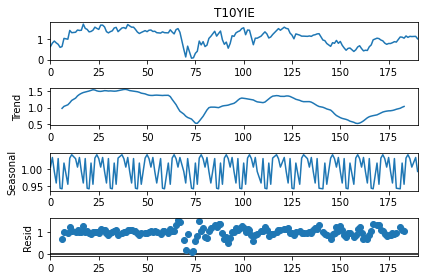

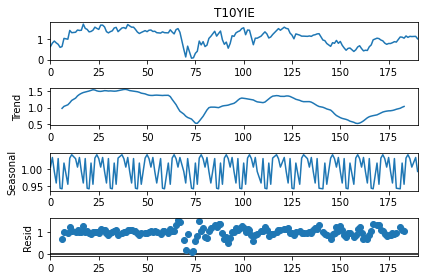

In [ ]:
result1=seasonal_decompose(abs(BER10['T10YIE']), model='multiplicable', period=12)
result1.plot()

In [ ]:
result1.seasonal

0      1.006957
1      1.035537
2      0.994017
3      0.959728
4      1.032341
         ...   
185    1.043809
186    1.032105
187    1.006957
189    1.035537
190    0.994017
Name: seasonal, Length: 171, dtype: float64

In [ ]:
BER10['T10YIE'] = BER10['T10YIE']-result1.seasonal

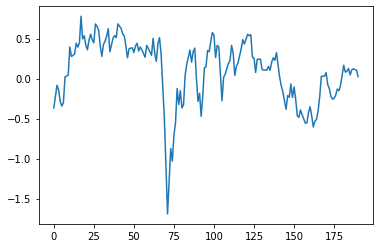

In [ ]:
plt.plot(BER10['T10YIE'])

In [ ]:
BER5['T5YIE'] = BER5['T5YIE']-result.seasonal

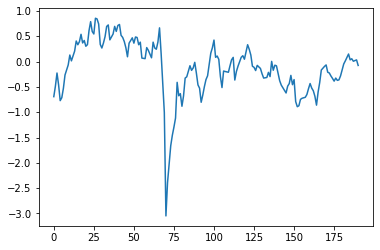

In [ ]:
plt.plot(BER5['T5YIE'])